## Priors after inverting
I will do the same as in the second approach for the linear scal. This means creating an aggregated objective consisting of the neg-log-likelihood and the neg-log-prior (laplacian). Both take parameters on linear scale as an input, so I concatenate it again with the inverse function of the different scaling functions, because parameters and bounds in the petab problem are on some other scale. 
This should be the same as if I would take different priors on the scaled parameters (scaled laplacian).
A second approach I might consider later is to implement the regularization not via prios but via adding the penalty term to the objective and then concatenate with the inverse scaling functions. We will see what works better and whether results are different. 

In [1]:
import libsbml
import importlib
import os
import sys
import shutil
import pandas as pd



import amici
import matplotlib.pyplot as plt
import numpy as np 
import petab 
from petab.C import *

import pypesto
import pypesto.optimize as optimize
import pypesto.petab
import pypesto.visualize as visualize
import pypesto.objective

In [2]:
def make_prior(petab_problem, strength, scale='lin'): 
  prior_list = []

  for i in range(len(petab_problem.get_model_parameters())):
    priorType = 'laplace'
    priorParameters = [0, 1/strength]
    priorScale = scale
    prior = pypesto.objective.get_parameter_prior_dict(i, priorType, priorParameters, priorScale)
    prior_list.append(prior)

  return pypesto.objective.NegLogParameterPriors(prior_list)

## Log-shift scale
First for the $\log_{10}(1+x)$  scaling function.

In [ ]:
model_name= "Spoegler_conversionReaction"
param_scale= "log10_shift"


# the yaml file includes all important links to other files
yaml_config ="petab/"+param_scale+"/"+model_name+".yaml"
# create a petab problem
petab_problem = petab.Problem.from_yaml(yaml_config)

# or create from folder (did not work)
# petab_problem = petab.Problem.from_folder("petab/"+param_scale)

# import to amici
importer = pypesto.petab.PetabImporter(petab_problem)
importer.compile_model()

model = importer.create_model()

In [4]:
# initialize solver and options
solver = importer.create_solver(model)

# enable sensitivities
solver.setSensitivityOrder(amici.SensitivityOrder_first)       
solver.setSensitivityMethod(amici.SensitivityMethod_forward)  
model.requireSensitivitiesForAllParameters()                   

In [5]:
# linear objective function
lin_log_likelihood = importer.create_objective()

# create priors on linear scale
strength = 1
lin_log_prior = make_prior(petab_problem, strength)

# aggregate objective function
lin_log_posterior = pypesto.objective.AggregatedObjective([lin_log_likelihood, lin_log_prior])



# shifted parameter
eps = 1
def fun(x):
    return lin_log_posterior.get_fval(10**np.array(x)-eps)

def grad(x):
    return lin_log_posterior.get_grad(10**np.array(x)-eps) * 10**np.array(x) * np.log(10)


# new objective function
neg_log_posterior = pypesto.Objective(fun=fun, grad=grad)

Using existing amici model in folder /home/vinc777/python_projects/moses/spoegler_model_reduction/l1_regularization/amici_models/Sp_gler_ConversionReaction.


In [9]:
print('optimal x = ', petab_problem.x_nominal)
print('optimal lh value', neg_log_posterior(petab_problem.x_nominal))

optimal x =  [0.07918125, 0.04139269, 0.0, 0.17609126]
optimal lh value -0.7491889568305559


In [ ]:
# create optimizer object
optimizer = optimize.ScipyOptimizer()

# create problem object
problem = importer.create_problem(objective=neg_log_posterior)

# do the optimization
n_starts = 100

result = optimize.minimize(problem=problem, optimizer=optimizer, n_starts=n_starts, filename=None)

In [14]:
# print results
best_result=result.optimize_result.as_list("x")[0]["x"]
print('best parameter: ', best_result)
print('best likelihood value: ', problem.objective(best_result[0:3]))

best parameter:  [0.10042984 0.0287449  0.00068498 0.17609126]
best likelihood value:  -1.6549686229069285


<AxesSubplot:title={'center':'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Function value'>

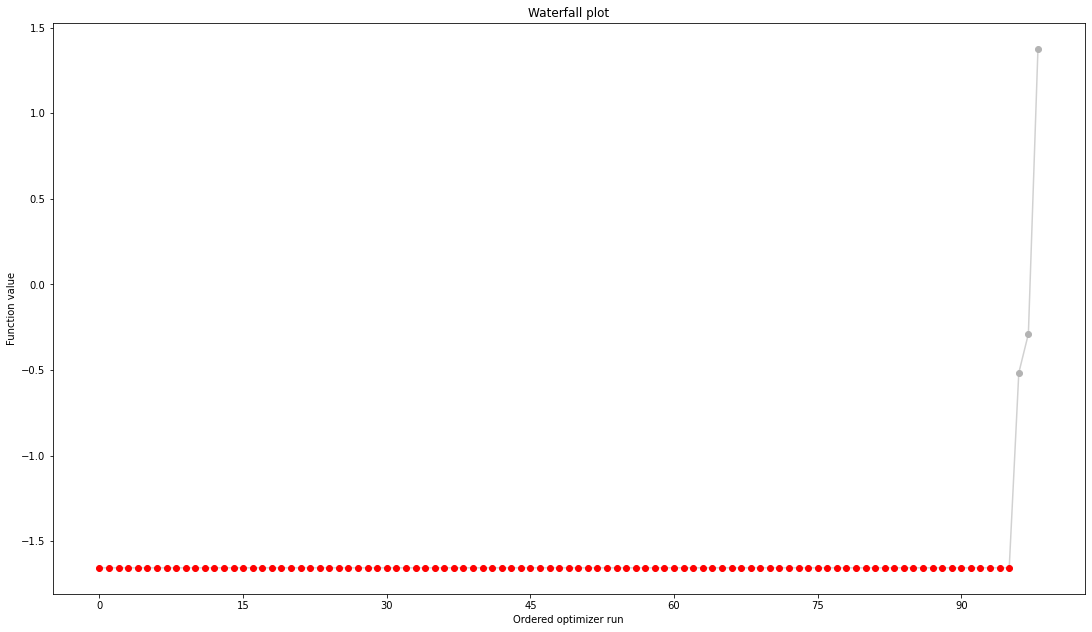

In [12]:
# waterfall plot
fvals = result.optimize_result.get_for_key("fval")
fval = np.array(fvals)
fval=fval[fval < 1e2]
visualize.waterfall_lowlevel(fval, scale_y='lin')

In [15]:
# converged means close to the best result up to a threshold

threshold = 1e-2
n_compares = len(result.optimize_result.as_list("x"))
n_converged = 0
for i in range(0, n_compares):
    compare_result = result.optimize_result.as_list("x")[i]["x"]
    converged = (np.abs((compare_result - best_result)) < (threshold * len(compare_result))).all()
    if converged:
        n_converged += 1

print("Number of converged runs: ", n_converged) 

Number of converged runs:  99


<AxesSubplot:title={'center':'Estimated parameters'}, xlabel='Parameter value', ylabel='Parameter'>

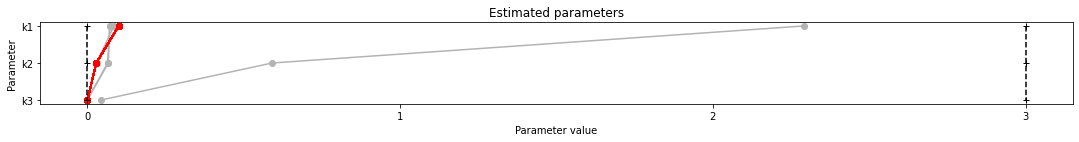

In [16]:
visualize.parameters(result)

## Logicle Scale 
Now the same for parameters on the logicle scale.

In [18]:
from LogicleScale import    logicleTransform, \
                            logicleInverseTransform, \
                            function_parameters, \
                            logicleGradient, \
                            logicleInverseGradient

In [ ]:
model_name= "Spoegler_conversionReaction"
param_scale= "logicle"


# the yaml file includes all important links to other files
yaml_config ="petab/"+param_scale+"/"+model_name+".yaml"
# create a petab problem
petab_problem = petab.Problem.from_yaml(yaml_config)

# or create from folder (did not work)
# petab_problem = petab.Problem.from_folder("petab/"+param_scale)

# import to amici
importer = pypesto.petab.PetabImporter(petab_problem)
importer.compile_model()

model = importer.create_model()

In [20]:
# initialize solver and options
solver = importer.create_solver(model)

# enable sensitivities
solver.setSensitivityOrder(amici.SensitivityOrder_first)       
solver.setSensitivityMethod(amici.SensitivityMethod_forward)  
model.requireSensitivitiesForAllParameters()    

In [21]:
# linear objective function
lin_log_likelihood = importer.create_objective()

# create priors on linear scale
strength = 1
lin_log_prior = make_prior(petab_problem, strength)

# aggregate objective function
lin_log_posterior = pypesto.objective.AggregatedObjective([lin_log_likelihood, lin_log_prior])



# shifted parameter
T= 1000
trans = 1e-5

def fun(x):
    return lin_log_posterior.get_fval(logicleInverseTransform(scaled=x, T=T, trans=trans))

def grad(x):
    return lin_log_posterior.get_grad(logicleInverseTransform(scaled=x, T=T, trans=trans)) * logicleInverseGradient(scaled=x, T=T, trans=trans)


# new objective function
neg_log_posterior = pypesto.Objective(fun=fun, grad=grad)

Using existing amici model in folder /home/vinc777/python_projects/moses/spoegler_model_reduction/l1_regularization/amici_models/Sp_gler_ConversionReaction.


In [22]:
print('optimal x = ', petab_problem.x_nominal)
print('optimal lh value', neg_log_posterior(petab_problem.x_nominal))

optimal x =  [0.18031863, 0.15425572, 0.0, 0.15425572]
optimal lh value 20.396244029948406


In [ ]:
# create optimizer object
optimizer = optimize.ScipyOptimizer()

# create problem object
problem = importer.create_problem(objective=neg_log_posterior)

# do the optimization
n_starts = 100

result = optimize.minimize(problem=problem, optimizer=optimizer, n_starts=n_starts, filename=None)

In [24]:
# print results
best_result=result.optimize_result.as_list("x")[0]["x"]
print('best parameter: ', best_result)
print('best likelihood value: ', problem.objective(best_result[0:3]))

best parameter:  [0.20644956 0.08859305 0.00246253 0.15425572]
best likelihood value:  -2.194392390817063


<AxesSubplot:title={'center':'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Function value'>

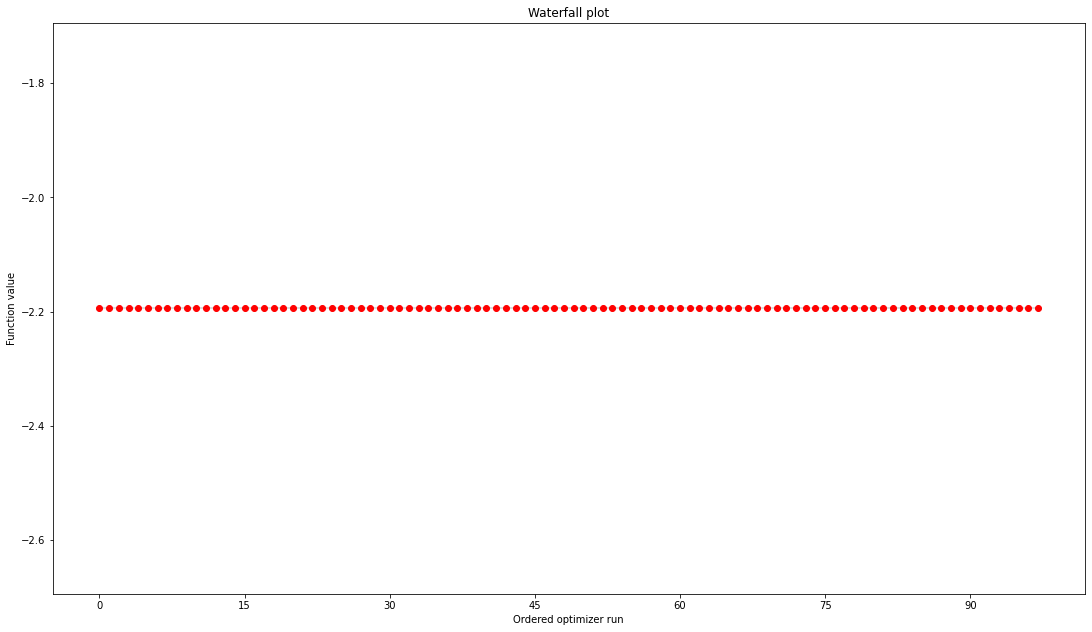

In [25]:
# waterfall plot
fvals = result.optimize_result.get_for_key("fval")
fval = np.array(fvals)
fval=fval[fval < 1e2]
visualize.waterfall_lowlevel(fval, scale_y='lin')

In [26]:
# converged means close to the best result up to a threshold

threshold = 1e-2
n_compares = len(result.optimize_result.as_list("x"))
n_converged = 0
for i in range(0, n_compares):
    compare_result = result.optimize_result.as_list("x")[i]["x"]
    converged = (np.abs((compare_result - best_result)) < (threshold * len(compare_result))).all()
    if converged:
        n_converged += 1

print("Number of converged runs: ", n_converged) 

Number of converged runs:  98


<AxesSubplot:title={'center':'Estimated parameters'}, xlabel='Parameter value', ylabel='Parameter'>

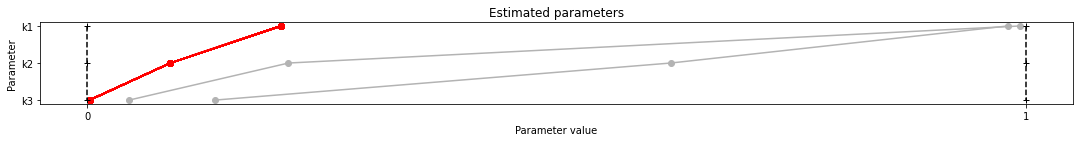

In [27]:
visualize.parameters(result)